In [ ]:
"""
Conclusion: As per the literature - the mean parameter and the covariance or inverse covariance
parameter may be treated seperatley by cholesky or spectral decomposition
cholesky  S = AA.T
spectral  S = UV inv(U)
The entries of the diagonal matrix V are the eigen values. 

Spectral Theorem - diagonalize matrices
- Every real symmetric matrix is diagonizable
- 


"""

In [28]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import pyext.src.matrix as mat
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

key = jax.random.PRNGKey(13)

import sklearn

p = 8
cov = np.eye(p)
cov[0, 1] = 0.5
cov[0, 2] = -0.3
cov[0, 6] = 0.1
cov[3, 5] = 0.4342
cov = cov + cov.T
cov = np.array(cov)
cov[np.diag_indices(p)] = 1.
assert mat.is_positive_definite(cov)

mean = jnp.arange(p)

In [139]:
mpl.rcParams["font.size"] = 16

In [3]:
nsamples = 1000
x = jax.random.multivariate_normal(key, mean, cov, shape=(nsamples,))
x = np.array(x)
nrows, ncols = x.shape
ij = []

def get_pearsonr(x):
    c=0
    rs = np.zeros(int(p * (p - 1) // 2))
    ps = np.zeros(int(p * (p - 1) // 2))

    for i in range(ncols):
        for j in range(i+1, ncols):
            r, pval = sp.stats.pearsonr(x[:, i], x[:, j])
            rs[c] = r
            ps[c] = pval
            ij.append((i, j))
            c+=1

    return rs, ps
rs, ps = get_pearsonr(x)

covs = []
for t in ij:
    covs.append(cov[t])

In [4]:
def latent_model(key, mu, cov, p, nsamples):
    z = jax.random.normal(key, shape=(p, nsamples))
    U = jsp.linalg.cholesky(cov)
    x = mean + z.T @ U
    x = np.array(x)
    z = np.array(z)
    U = np.array(U)
    return x, z, U

In [173]:
testm = cov[0:4, 0:4]

In [178]:
jsp.linalg.cholesky(testm, lower=True).T

DeviceArray([[ 1.        ,  0.5       , -0.3       ,  0.        ],
             [ 0.        ,  0.8660254 ,  0.17320508,  0.        ],
             [ 0.        ,  0.        ,  0.9380832 ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  1.        ]],            dtype=float32)

In [177]:
jsp.linalg.cholesky(testm)

DeviceArray([[ 1.        ,  0.5       , -0.3       ,  0.        ],
             [ 0.        ,  0.8660254 ,  0.17320508,  0.        ],
             [ 0.        ,  0.        ,  0.9380832 ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  1.        ]],            dtype=float32)

In [5]:
# M1 x | mu cov
# M2 x | 0  cov
# M3 x | mu, z, A ; A | cov, z ~ N(0, 1)

Text(0.5, 1.0, 'Full model N(mu, cov)\np=8 N=1000')

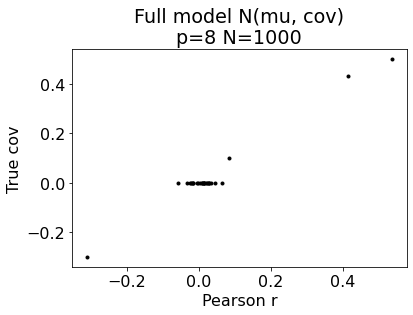

In [140]:
#mpl.rcParams["font.size"] = 1
mpl.rcParams["font.style"] = "normal"
plt.plot(rs, covs, 'k.')
plt.xlabel("Pearson r")
plt.ylabel("True cov")
plt.title(f"Full model N(mu, cov)\np={p} N={nsamples}")

Text(0, 0.5, 'True cov')

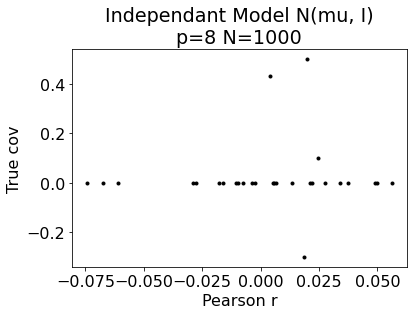

In [141]:
# Independant model
x_ind = jax.random.multivariate_normal(key, mean, jnp.eye(p), shape=(nsamples,))
x_ind = np.array(x_ind)
rs, ps = get_pearsonr(x_ind)
plt.title(f"Independant Model N(mu, I)\np={p} N={nsamples}")
plt.plot(rs, covs, 'k.')
plt.xlabel("Pearson r")
plt.ylabel("True cov")

Text(0, 0.5, 'True cov')

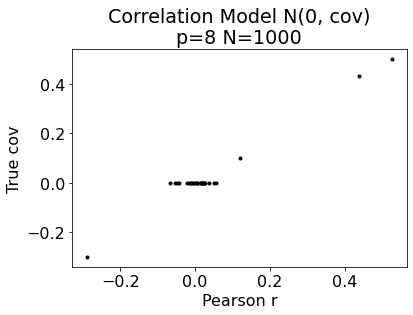

In [142]:
# Just Correlations
x_corr = jax.random.multivariate_normal(key, jnp.zeros(p), cov, shape=(nsamples,))
x_corr = np.array(x_corr)
rs, ps = get_pearsonr(x_corr)
plt.title(f"Correlation Model N(0, cov)\np={p} N={nsamples}")
plt.plot(rs, covs, 'k.')
plt.xlabel("Pearson r")
plt.ylabel("True cov")

Text(0, 0.5, 'True cov')

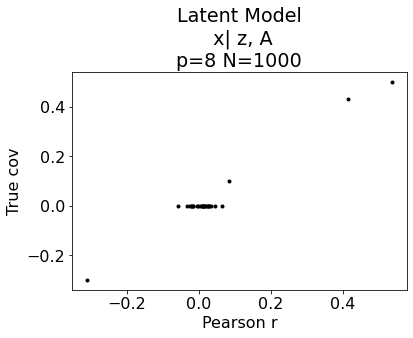

In [143]:
# Latent model
x_latent, z, U = latent_model(key, mean, cov, p, nsamples)
rs, ps = get_pearsonr(x_latent)
plt.title(f"Latent Model\n x| z, A\np={p} N={nsamples}")
plt.plot(rs, covs, 'k.')
plt.xlabel("Pearson r")
plt.ylabel("True cov")

In [24]:
x_full_means = get_means(x)
x_ind_means = get_means(x_ind)
x_corr_means = get_means(x_corr)
x_latent_means = get_means(x_latent)

Text(0, 0.5, 'sample mean')

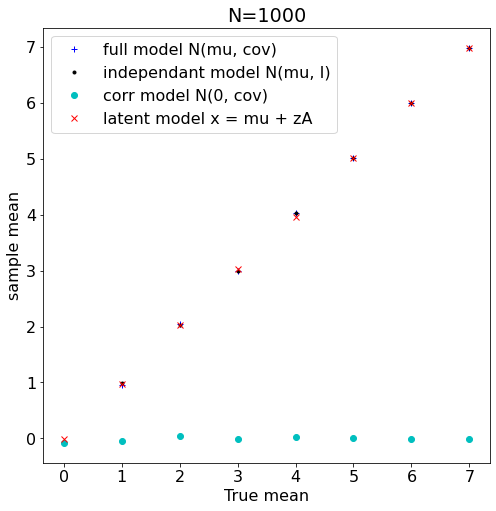

In [166]:
s = 8
w = s
h = s
fig = plt.figure(figsize=(w, h))
plt.title(f"N={nsamples}")
plt.plot(mean, x_full_means, 'b+', label="full model N(mu, cov)")
plt.plot(mean, x_ind_means, 'k.', label="independant model N(mu, I)")
plt.plot(mean, x_corr_means, 'co', label="corr model N(0, cov)")
plt.plot(mean, x_latent_means, 'rx', label="latent model x = mu + zA")
plt.legend()
plt.xlabel("True mean")
plt.ylabel("sample mean")

In [167]:
?plt.plot

In [96]:
"""
Methods of computing the determinant?
Directly
"""
L = jsp.linalg.cholesky(cov)
Ld = L[jnp.diag_indices(p)]
U, s, Vh = jsp.linalg.svd(cov)
print(f"det(cov) jnp.linalg.det {jnp.linalg.det(cov)}")
print(f"det(cov) jsp.linalg.det {jsp.linalg.det(cov)}")
print(f"det(L)^2      cholesky  {jnp.prod(Ld)**2}")
print("\n")
print(f"log det cov             {jnp.log(jnp.linalg.det(cov))}")
print(f"log det(L)^2            {jnp.log(jnp.prod(Ld)**2)}")
print(f"2 Sum log Ld            {2 * jnp.sum(jnp.log(Ld))}")
print("\n")
print("-----svd-------")
print(f"svd prod(s)             {jnp.prod(s)}")
print(f"svd sum log s           {jnp.sum(jnp.log(s))}")
print("-----svd--------")


print("------LU--------")

print("----------------")


print("--------QR-------")
"""
X=QR. Q is an orthogonal matrix. R is an upper triangular matrix. can be used for least squares.

"""

det(cov) jnp.linalg.det 0.5274556875228882
det(cov) jsp.linalg.det 0.5274556875228882
det(L)^2      cholesky  0.527455747127533


log det cov             -0.6396903991699219
log det(L)^2            -0.6396902799606323
2 Sum log Ld            -0.6396902799606323


-----svd-------
svd prod(s)             0.5274558067321777
svd sum log s           -0.6396902203559875
-----svd--------
------LU--------
----------------


In [102]:
L @ L.T

DeviceArray([[ 1.35      ,  0.37527767, -0.27716094,  0.        ,
               0.        ,  0.        ,  0.09923954,  0.        ],
             [ 0.37527767,  0.7833333 ,  0.16001894,  0.        ,
               0.        ,  0.        , -0.05729597,  0.        ],
             [-0.27716094,  0.16001894,  0.88181823,  0.        ,
               0.        ,  0.        ,  0.04231588,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  1.1885296 ,
               0.        ,  0.3911345 ,  0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.        ,
               1.        ,  0.        ,  0.        ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.3911345 ,
               0.        ,  0.8114704 ,  0.        ,  0.        ],
             [ 0.09923954, -0.05729597,  0.04231588,  0.        ,
               0.        ,  0.        ,  0.9848485 ,  0.        ],
             [ 0.        ,  0.        ,  0.        ,  0.        ,
   

In [134]:
A = jsp.linalg.cholesky(cov)
A = A.T
V = 1 * cov
L = jsp.linalg.cholesky(V)
S = L @ A @ A.T @ L.T
mat.is_positive_definite(S)
inv = jsp.linalg.inv
print(f"trace term {-jnp.trace(inv(L @ L.T) @ S)}")
print(f"trace A, L {-_trace_term(L, A)}")

trace term -8.0
trace A, L -8.0


In [ ]:
"""
inv(V) @ S
inv(L @ L.T) @ L @ A @ A.T @ L.T
inv(L.T) @ inv(L) @ L @ A @ A.T @ L.T
inv(L.T) @ A @ A.T @ L.T

"""

In [126]:
def _trace_term(L, A):
    return jnp.trace(inv(L.T) @ A @ A.T @ L.T)

In [ ]:
import jax.scipy as jsp

In [ ]:
?jnp.linalg.norm

In [ ]:
plt.plot(x[:, 0], x[:, 1], 'k.')

In [ ]:
?np.linalg.norm